In [83]:
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, shapiro, chisquare
import statsmodels.formula.api as sfm
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV



In [45]:
df = pd.read_csv('udemy_database.csv')
df_no_outliers_udemy = pd.read_csv('udemy_database_no_outliers.csv')

RELATIONSHIP BETWEEN VARIABLES

BOX 1: COVARIANCE MATRIX

In [46]:
numeric_columns = ['price', 'num_subscribers', 'num_reviews', 'num_lectures', 'content_duration']
numeric_data = df_no_outliers_udemy[numeric_columns]

covariance_matrix = numeric_data.cov()

print("Covariance Matrix:")
print(covariance_matrix)

Covariance Matrix:
                         price  num_subscribers   num_reviews  num_lectures  \
price              3645.936818     1.185530e+04  2.120575e+03    754.796010   
num_subscribers   11855.304132     6.815058e+07  2.593905e+06  32633.721229   
num_reviews        2120.574798     2.593905e+06  2.019934e+05   4186.163758   
num_lectures        754.796010     3.263372e+04  4.186164e+03   1591.539958   
content_duration     79.648912     4.376883e+03  4.638909e+02    142.150486   

                  content_duration  
price                    79.648912  
num_subscribers        4376.883118  
num_reviews             463.890947  
num_lectures            142.150486  
content_duration         19.325105  


BOX 2 Correlation - spearman coeff

In [47]:
spearman_corr = numeric_data.corr(method='spearman')
print("Spearman Correlation Matrix:")
print(spearman_corr)

Spearman Correlation Matrix:
                     price  num_subscribers  num_reviews  num_lectures  \
price             1.000000         0.059589     0.138364      0.377885   
num_subscribers   0.059589         1.000000     0.781211      0.199459   
num_reviews       0.138364         0.781211     1.000000      0.333735   
num_lectures      0.377885         0.199459     0.333735      1.000000   
content_duration  0.344380         0.155703     0.312790      0.800676   

                  content_duration  
price                     0.344380  
num_subscribers           0.155703  
num_reviews               0.312790  
num_lectures              0.800676  
content_duration          1.000000  


BOX 3: the relationship between all numeric variables 2 by 2 

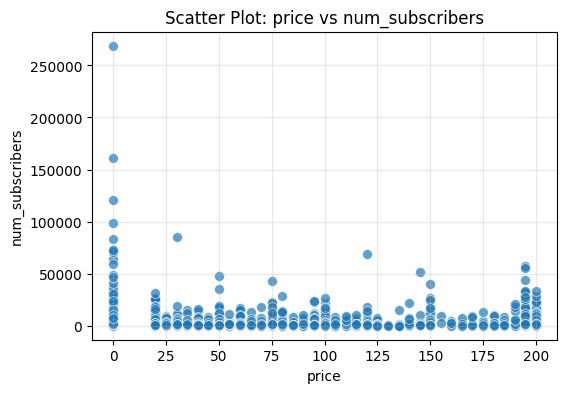

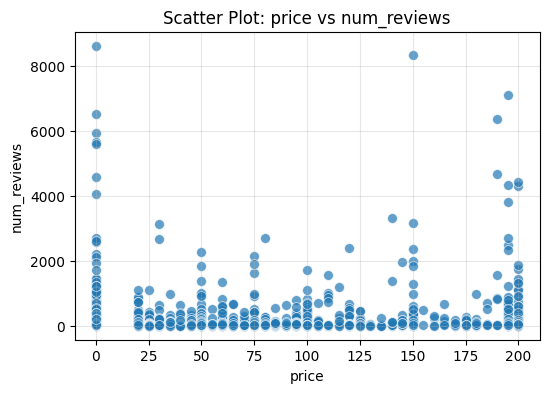

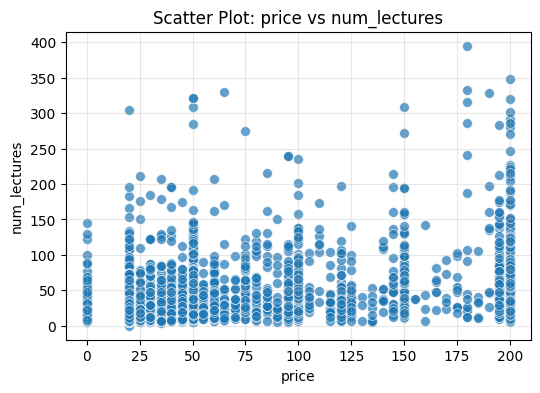

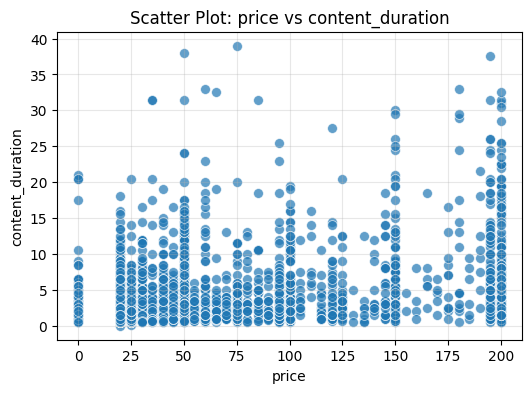

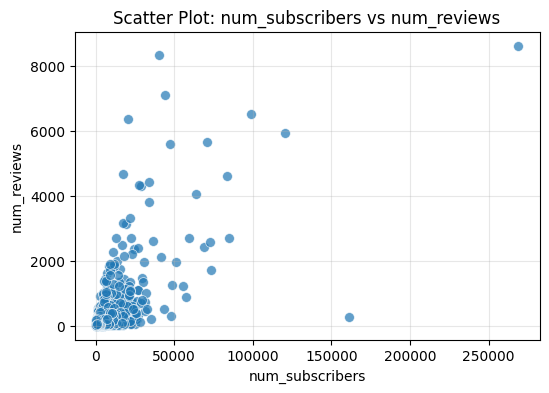

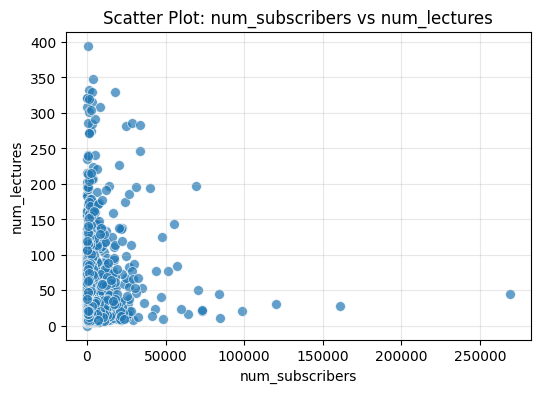

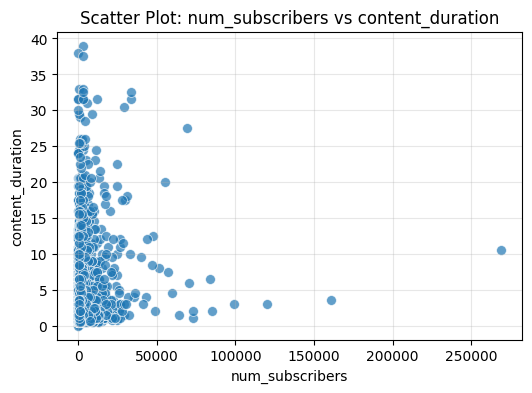

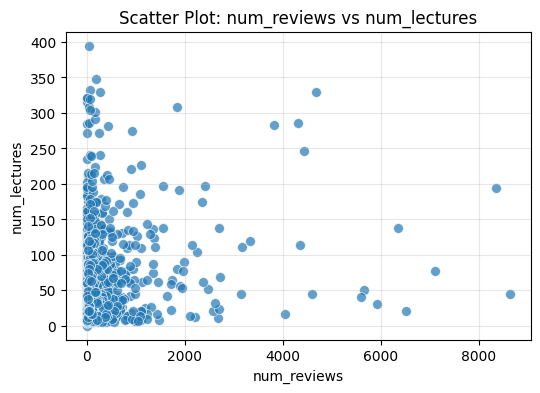

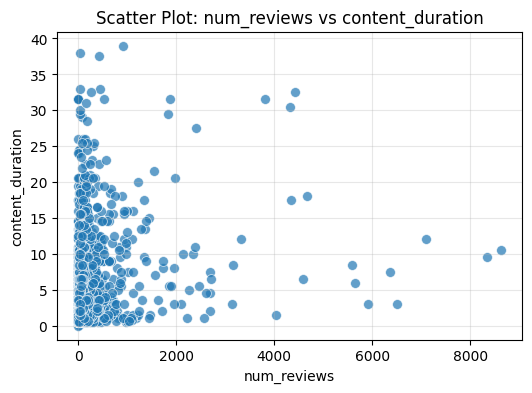

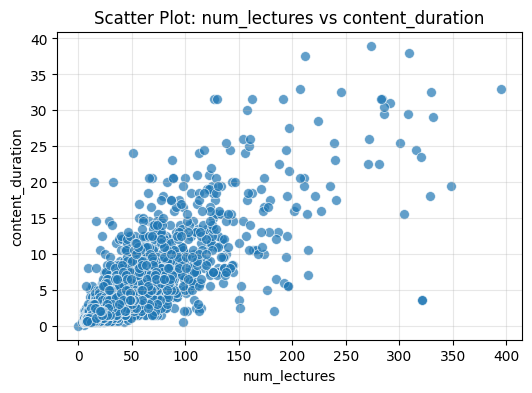

In [48]:
for i, col1 in enumerate(numeric_columns):
    for col2 in numeric_columns[i+1:]:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=numeric_data, x=col1, y=col2, alpha=0.7, s=50)
        plt.title(f"Scatter Plot: {col1} vs {col2}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.grid(alpha=0.3)
        plt.show()

BOX 4: Multicollinearity - Correlation Matrix

In [49]:
correlation_matrix = df_no_outliers_udemy.select_dtypes(include=['float64', 'int64']).corr()
print(correlation_matrix)

                  course_id     price  num_subscribers  num_reviews  \
course_id          1.000000  0.148260        -0.155283    -0.081856   
price              0.148260  1.000000         0.023783     0.078141   
num_subscribers   -0.155283  0.023783         1.000000     0.699118   
num_reviews       -0.081856  0.078141         0.699118     1.000000   
num_lectures      -0.008727  0.313340         0.099088     0.233474   
content_duration  -0.036473  0.300064         0.120606     0.234794   

                  num_lectures  content_duration  
course_id            -0.008727         -0.036473  
price                 0.313340          0.300064  
num_subscribers       0.099088          0.120606  
num_reviews           0.233474          0.234794  
num_lectures          1.000000          0.810548  
content_duration      0.810548          1.000000  


VIF

In [50]:
X = df_no_outliers_udemy[['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration', 'level', 'subject']]  # Independent variables

X = pd.get_dummies(X, drop_first=False).astype(float)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
                        Feature       VIF
0               num_subscribers  2.060486
1                   num_reviews  2.073372
2                  num_lectures  3.032007
3              content_duration  3.038133
4              level_All Levels       inf
5          level_Beginner Level       inf
6            level_Expert Level       inf
7      level_Intermediate Level       inf
8      subject_Business Finance       inf
9        subject_Graphic Design       inf
10  subject_Musical Instruments       inf
11      subject_Web Development       inf


c:\users\teodo\appdata\local\activestate\cache\f496fb7e\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


STARTING THE REGRESSION

creating interaction terms since the correlation is high between num_lectures-content_duration and num_reviews-num_subscribers

In [51]:
df_no_outliers_udemy['num_lectures_content_duration'] = df_no_outliers_udemy['num_lectures'] * df_no_outliers_udemy['content_duration']
df_no_outliers_udemy['num_subscribers_num_reviews'] = df_no_outliers_udemy['num_subscribers'] * df_no_outliers_udemy['num_reviews']


1. MULTIPLE LINEAR REGRESSION - without outliers and without interaction terms

In [52]:
X = df_no_outliers_udemy[['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration', 'subject']]  
y = df_no_outliers_udemy['price'] 

X = pd.get_dummies(X, drop_first=False)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr = LinearRegression()
lr.fit(X_scaled, y)

mse = mean_squared_error(y, lr.predict(X_scaled))
r2 = r2_score(y, lr.predict(X_scaled))

print("Mean Squared Error:", mse)
print("R-squared:", r2)

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})

print("\nLinear Regression Coefficients:")
print(coefficients)

Mean Squared Error: 3202.6233882700362
R-squared: 0.12134903671496289

Linear Regression Coefficients:
                       Feature   Coefficient
0              num_subscribers -2.699906e+00
1                  num_reviews  4.782346e-01
2                 num_lectures  1.346219e+01
3             content_duration  6.161955e+00
4     subject_Business Finance -1.571248e+15
5       subject_Graphic Design -1.240708e+15
6  subject_Musical Instruments -1.305581e+15
7      subject_Web Development -1.570558e+15


MULTIMPLE LINEAR REGRESSION WITH INTERACTION TERM

In [53]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures_content_duration', 'subject']]  
y = df_no_outliers_udemy['price'] 

X = pd.get_dummies(X, drop_first=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})

print("\nLinear Regression Coefficients:")
print(coefficients)



Mean Squared Error: 3390.840691250336
R-squared: 0.07112167615607734

Linear Regression Coefficients:
                         Feature   Coefficient
0    num_subscribers_num_reviews -1.601874e+00
1  num_lectures_content_duration  1.485734e+01
2       subject_Business Finance -9.307924e+14
3         subject_Graphic Design -7.439848e+14
4    subject_Musical Instruments -7.814066e+14
5        subject_Web Development -9.412044e+14


2. POLINOMIAL REGRESSION 

In [54]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'subject']]
y = df_no_outliers_udemy['price']

X = pd.get_dummies(X, drop_first=False)

poly = PolynomialFeatures(degree=2)  # degree 2 for quadratic features
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

lr_poly = LinearRegression()
lr_poly.fit(X_train, y_train)

y_pred = lr_poly.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 3328.747651311886
R-squared: 0.08813128648935831


In [55]:
X = df_no_outliers_udemy[['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration', 'subject']]
y = df_no_outliers_udemy['price']

X = pd.get_dummies(X, drop_first=False)

poly = PolynomialFeatures(degree=2)  # degree 2 for quadratic features
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

lr_poly = LinearRegression()
lr_poly.fit(X_train, y_train)

y_pred = lr_poly.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 3935.461928961527
R-squared: -0.07807048840663877


Plotting the residuals => heteroscedasticity

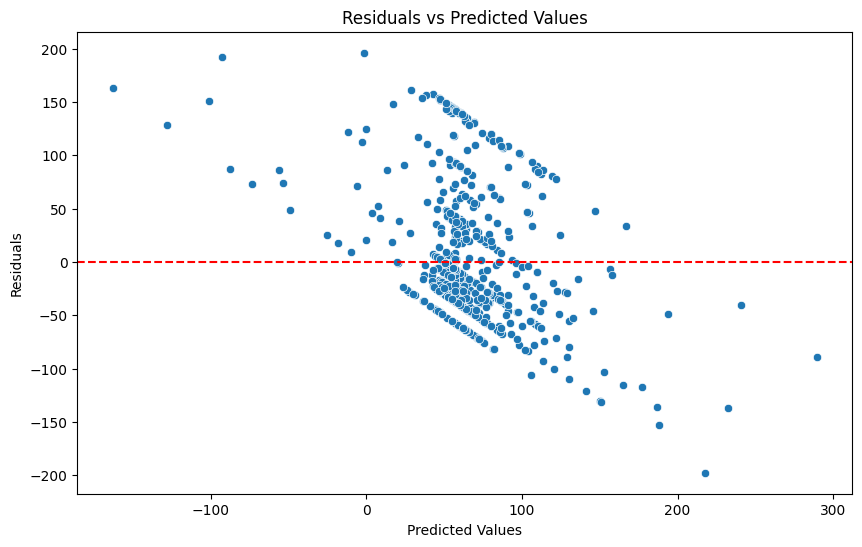

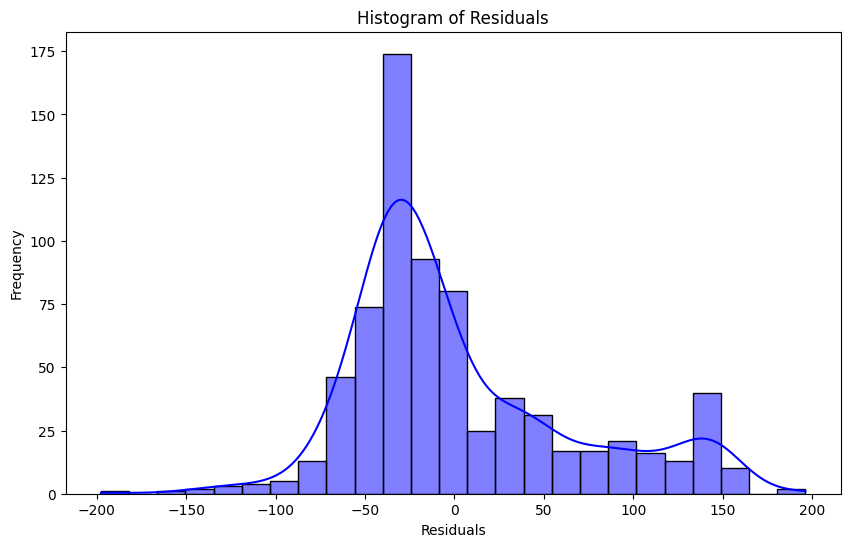

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Optionally: Plot histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


log-transformation on price

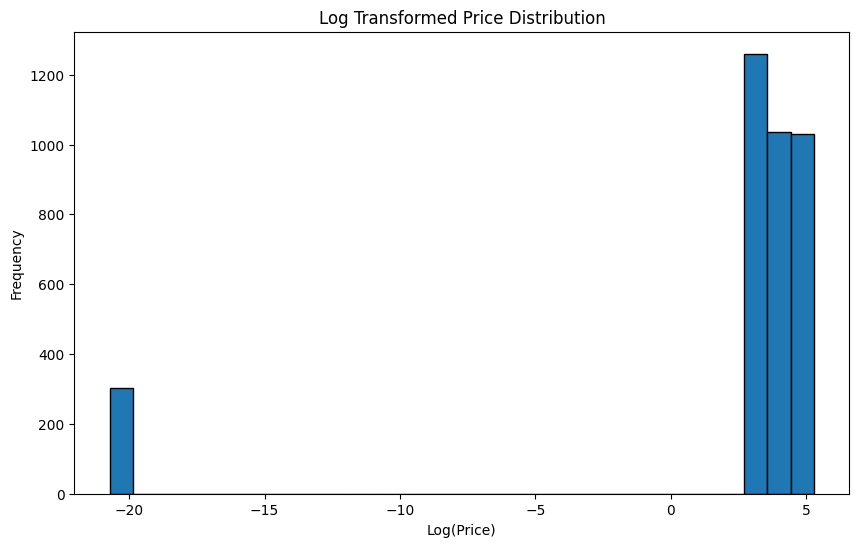

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Log transformation of price
df_no_outliers_udemy['price_log'] = np.log(df_no_outliers_udemy['price']+ 1e-9)

# Plotting the distribution of the log-transformed price
plt.figure(figsize=(10, 6))
plt.hist(df_no_outliers_udemy['price_log'], bins=30, edgecolor='black')
plt.title('Log Transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.show()


Box-Cox transformation

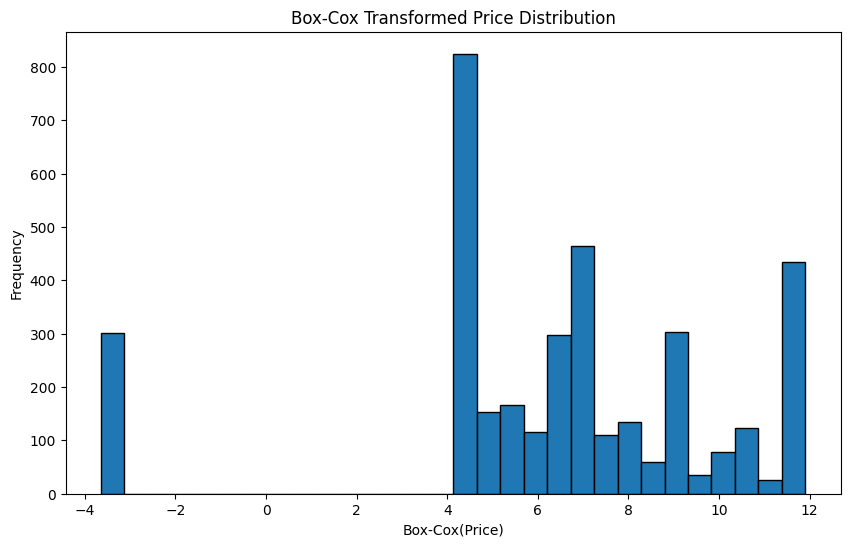

Lambda for Box-Cox transformation: 0.2732505653361542


In [58]:
from scipy import stats

# Adding a small constant to avoid zero or negative values
df_no_outliers_udemy['price_boxcox'] = df_no_outliers_udemy['price'] + 1e-9

# Applying Box-Cox transformation
df_no_outliers_udemy['price_boxcox'], lambda_boxcox = stats.boxcox(df_no_outliers_udemy['price_boxcox'])

# Plotting the distribution of the Box-Cox transformed price
plt.figure(figsize=(10, 6))
plt.hist(df_no_outliers_udemy['price_boxcox'], bins=30, edgecolor='black')
plt.title('Box-Cox Transformed Price Distribution')
plt.xlabel('Box-Cox(Price)')
plt.ylabel('Frequency')
plt.show()

# Check the lambda value for Box-Cox transformation
print(f"Lambda for Box-Cox transformation: {lambda_boxcox}")


Yeo-Johnson transformation on price

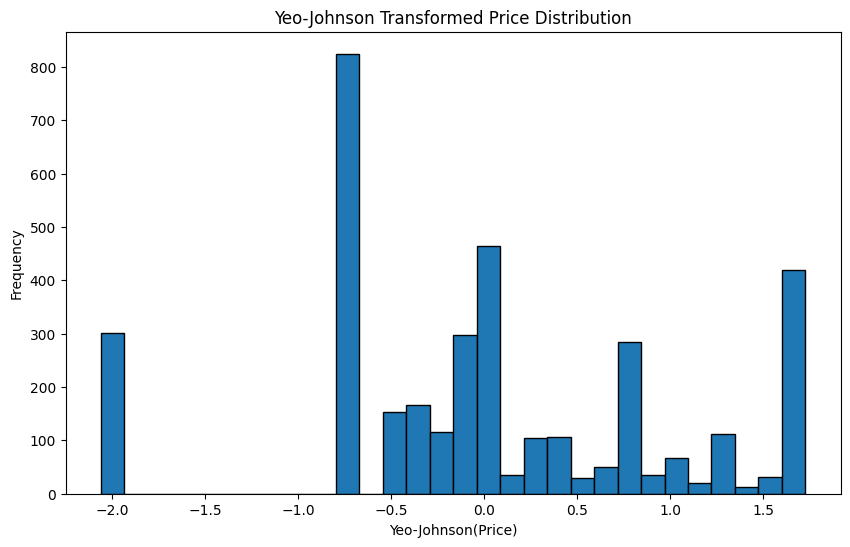

In [59]:
from sklearn.preprocessing import PowerTransformer

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df_no_outliers_udemy['price_yeojohnson'] = pt.fit_transform(df_no_outliers_udemy[['price']])

# Plotting the distribution of the Yeo-Johnson transformed price
plt.figure(figsize=(10, 6))
plt.hist(df_no_outliers_udemy['price_yeojohnson'], bins=30, edgecolor='black')
plt.title('Yeo-Johnson Transformed Price Distribution')
plt.xlabel('Yeo-Johnson(Price)')
plt.ylabel('Frequency')
plt.show()


Checking what transformation is the best => Yeo-Johnson

In [60]:
original_skew = df_no_outliers_udemy['price'].skew()
original_kurtosis = df_no_outliers_udemy['price'].kurtosis()

price_log_skew = df_no_outliers_udemy['price_log'].skew()
price_log_kurtosis = df_no_outliers_udemy['price_log'].kurtosis()

price_boxcox_skew = df_no_outliers_udemy['price_boxcox'].skew()
price_boxcox_kurtosis = df_no_outliers_udemy['price_boxcox'].kurtosis()

price_yeojohnson_skew = df_no_outliers_udemy['price_yeojohnson'].skew()
price_yeojohnson_kurtosis = df_no_outliers_udemy['price_yeojohnson'].kurtosis()

print(f"Original Price - Skewness: {original_skew}, Kurtosis: {original_kurtosis}")
print(f"Log Transformed Price - Skewness: {price_log_skew}, Kurtosis: {price_log_kurtosis}")
print(f"Box-Cox Transformed Price - Skewness: {price_boxcox_skew}, Kurtosis: {price_boxcox_kurtosis}")
print(f"Yeo-Johnson Transformed Price - Skewness: {price_yeojohnson_skew}, Kurtosis: {price_yeojohnson_kurtosis}")


Original Price - Skewness: 1.1829250686298813, Kurtosis: 0.18011342822538312
Log Transformed Price - Skewness: -2.9527605636346586, Kurtosis: 6.882878823872897
Box-Cox Transformed Price - Skewness: -1.076346477186815, Kurtosis: 1.5251635551910088
Yeo-Johnson Transformed Price - Skewness: -0.04405491220284836, Kurtosis: -0.23002714646044575


Redo all the regressions with Yeo-Johnson for price

linear regression with yeo johnson on price and num_subscribers_num_reviews as interaction term

In [79]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'subject']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
})

print("\nLinear Regression Coefficients:")
print(coefficients)

Mean Squared Error: 0.8993289410682566
R-squared: 0.1096175086543566

Linear Regression Coefficients:
                       Feature   Coefficient
0  num_subscribers_num_reviews -6.902268e-02
1                 num_lectures  2.285006e-01
2             content_duration  1.030734e-01
3     subject_Business Finance -2.693877e+13
4       subject_Graphic Design -2.153223e+13
5  subject_Musical Instruments -2.261528e+13
6      subject_Web Development -2.724011e+13


R-squared: 0.1561065343255541
Mean Squared Error: 0.843893465674446

Polynomial Regression Coefficients:
                                              Feature   Coefficient
0                         num_subscribers_num_reviews  2.210824e+10
1                                        num_lectures -6.550905e+12
2                                    content_duration  2.599685e+12
3                                    level_All Levels -1.643651e+11
4                                level_Beginner Level -6.028260e+11
5                                  level_Expert Level -4.145270e+11
6                            level_Intermediate Level -9.748430e+11
7                       num_subscribers_num_reviews^2  1.682644e-01
8            num_subscribers_num_reviews num_lectures  1.362419e-01
9        num_subscribers_num_reviews content_duration  9.302070e-03
10       num_subscribers_num_reviews level_All Levels -2.100461e+10
11   num_subscribers_num_reviews level_Beginner Level -6.915642e+09
12     num_

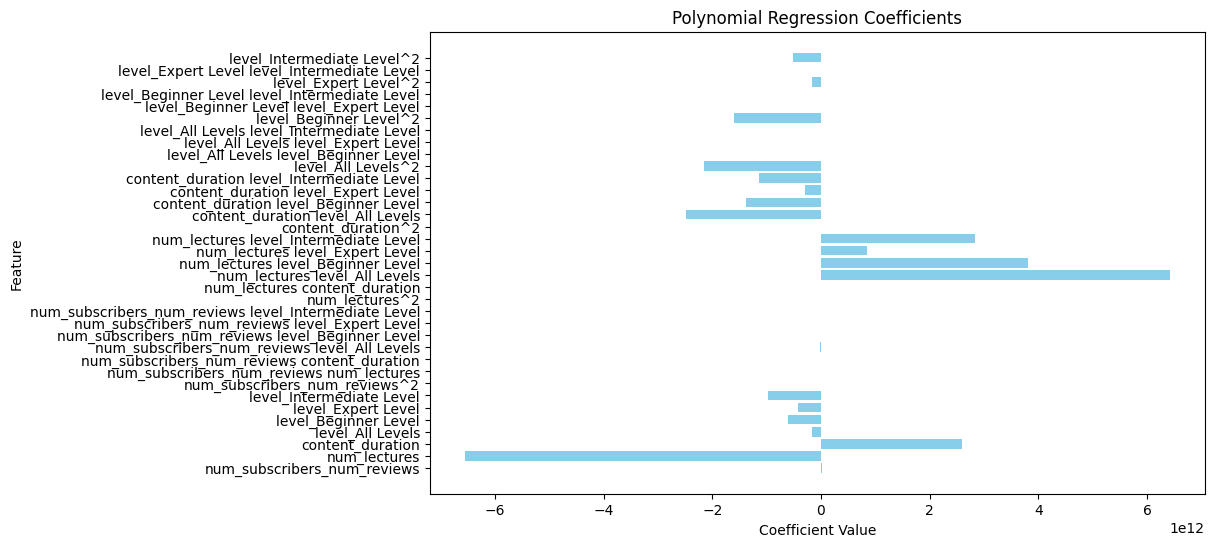

In [ ]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=False)

# Apply Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a linear regression model with polynomial features
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_poly_scaled, y)

# Evaluate the model
r2 = r2_score(y, lr.predict(X_poly_scaled))
mse = mean_squared_error(y, lr.predict(X_poly_scaled))

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

# Display model coefficients
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lr.coef_
})

print("\nPolynomial Regression Coefficients:")
print(coefficients)

plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Polynomial Regression Coefficients')
plt.show()


R-squared: 0.15853549921184473
Mean Squared Error: 0.8414645007881554

Polynomial Regression Coefficients:
                                               Feature   Coefficient
0                          num_subscribers_num_reviews  6.280079e+12
1                                         num_lectures  1.657180e+12
2                                     content_duration  1.407883e+11
3                             subject_Business Finance  5.762381e+12
4                               subject_Graphic Design  2.389534e+12
..                                                 ...           ...
114   subject_Graphic Design subject_Web Development^2  0.000000e+00
115                      subject_Musical Instruments^3  2.479624e+12
116  subject_Musical Instruments^2 subject_Web Deve...  0.000000e+00
117  subject_Musical Instruments subject_Web Develo...  0.000000e+00
118                          subject_Web Development^3  2.910284e+12

[119 rows x 2 columns]

Significant Coefficients:
              

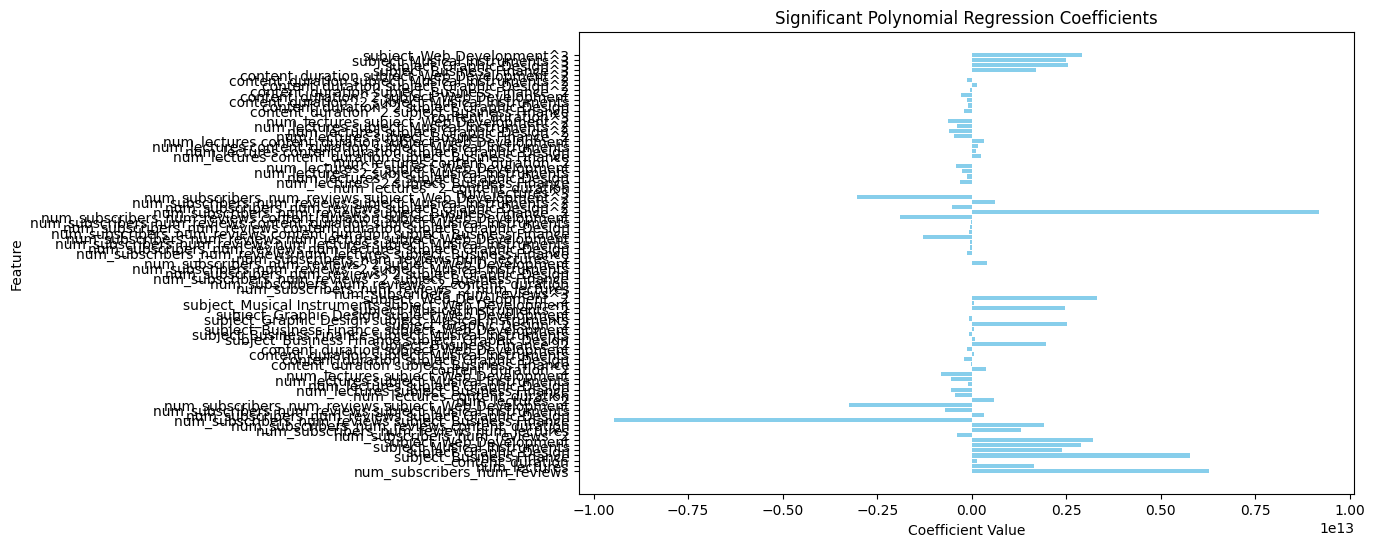

In [81]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'subject']]  
y = df_no_outliers_udemy['price_yeojohnson'] 

X = pd.get_dummies(X, drop_first=False)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

lr = LinearRegression()
lr.fit(X_poly_scaled, y)

# Evaluate the model
r2 = r2_score(y, lr.predict(X_poly_scaled))
mse = mean_squared_error(y, lr.predict(X_poly_scaled))

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

# Display model coefficients
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lr.coef_
})

print("\nPolynomial Regression Coefficients:")
print(coefficients)

significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]
print("\nSignificant Coefficients:")
print(significant_coefficients)

plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Polynomial Regression Coefficients')
plt.show()


simpliflied model, lost some meaning for the variance

R-squared: 0.15853549921184473
Mean Squared Error: 0.8414645007881554

Significant Coefficients:
                                        Feature   Coefficient
0                   num_subscribers_num_reviews  6.280079e+12
1                                  num_lectures  1.657180e+12
2                              content_duration  1.407883e+11
3                      subject_Business Finance  5.762381e+12
4                        subject_Graphic Design  2.389534e+12
..                                          ...           ...
98   content_duration subject_Web Development^2 -5.147468e+09
99                   subject_Business Finance^3  1.695900e+12
109                    subject_Graphic Design^3  2.533702e+12
115               subject_Musical Instruments^3  2.479624e+12
118                   subject_Web Development^3  2.910284e+12

[83 rows x 2 columns]
Simplified R-squared: 0.1815484420030461
Simplified Mean Squared Error: 0.818451557996954


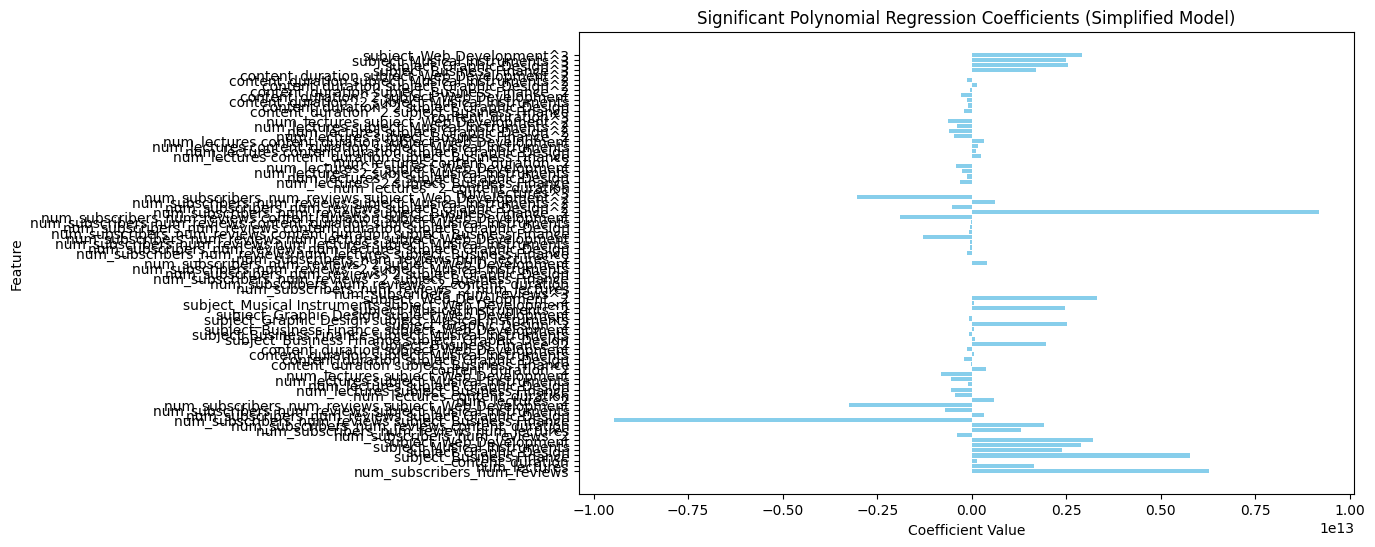

In [82]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'subject']]  
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=False)

# Apply Polynomial Features (degree 3 for higher complexity)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a linear regression model with polynomial features
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_poly_scaled, y)

# Evaluate the model
r2 = r2_score(y, lr.predict(X_poly_scaled))
mse = mean_squared_error(y, lr.predict(X_poly_scaled))

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

# Display significant model coefficients (absolute value > 0.1)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lr.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

print("\nSignificant Coefficients:")
print(significant_coefficients)

# Simplify by refitting with only significant features
significant_features = significant_coefficients['Feature']
significant_indices = [poly.get_feature_names_out(X.columns).tolist().index(f) for f in significant_features]
X_poly_significant = X_poly_scaled[:, significant_indices]

# Refit the model with significant features
lr_significant = LinearRegression()
lr_significant.fit(X_poly_significant, y)

# Evaluate the simplified model
r2_simplified = r2_score(y, lr_significant.predict(X_poly_significant))
mse_simplified = mean_squared_error(y, lr_significant.predict(X_poly_significant))

print(f"Simplified R-squared: {r2_simplified}")
print(f"Simplified Mean Squared Error: {mse_simplified}")

# Visualize significant coefficients for the simplified model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Polynomial Regression Coefficients (Simplified Model)')
plt.show()


lasso regression

c:\users\teodo\appdata\local\activestate\cache\f496fb7e\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5294883336787279, tolerance: 0.28025523126950935
  model = cd_fast.enet_coordinate_descent_gram(
c:\users\teodo\appdata\local\activestate\cache\f496fb7e\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.916668570856473, tolerance: 0.28025523126950935
  model = cd_fast.enet_coordinate_descent_gram(
c:\users\teodo\appdata\local\activestate\cache\f496fb7e\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.888812000468079, tolerance: 0.28025523126950935
  model = cd_fast.enet_coordinate_descent

Lasso R-squared: 0.14339813178230076
Lasso Mean Squared Error: 0.8566018682176993

Significant Coefficients (Lasso):
                                              Feature  Coefficient
0                         num_subscribers_num_reviews    -0.057331
1                                        num_lectures     0.346720
2                                    content_duration     0.114750
3                                level_Beginner Level    -0.077762
4                                  level_Expert Level     0.044569
5                            level_Intermediate Level    -0.004918
9    num_subscribers_num_reviews level_Beginner Level    -0.031540
10     num_subscribers_num_reviews level_Expert Level     0.003634
11  num_subscribers_num_reviews level_Intermediate...    -0.006123
12                                     num_lectures^2    -0.150078
18              content_duration level_Beginner Level     0.016297
21                             level_Beginner Level^2    -0.017960
24          

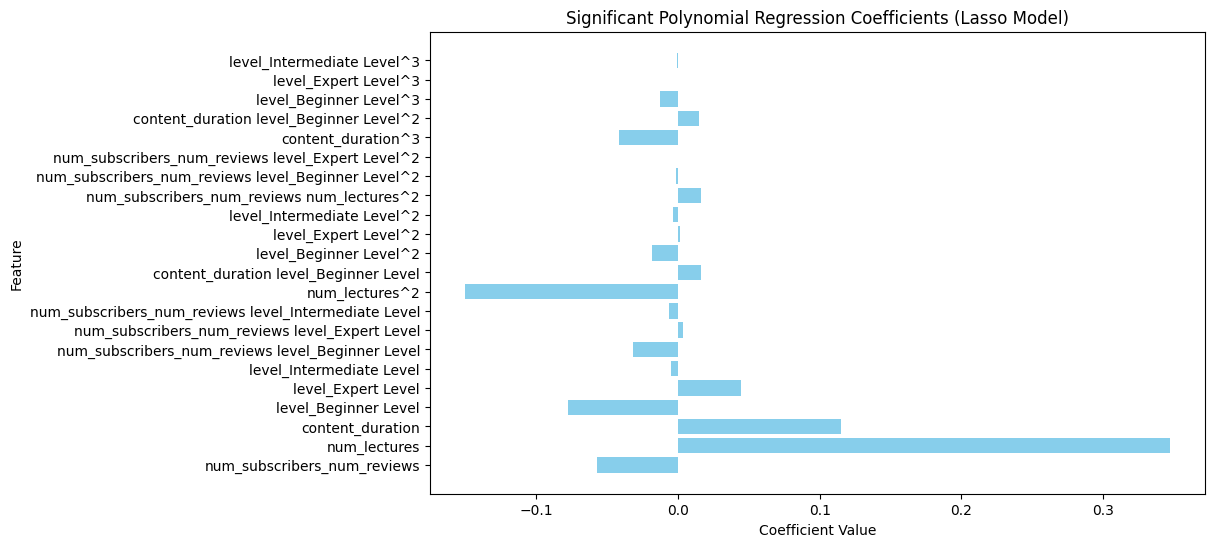

In [65]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]  # Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Apply Polynomial Features (degree 3 for higher complexity)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a Lasso regression model with polynomial features
lasso = LassoCV(cv=5, random_state=42).fit(X_poly_scaled, y)

# Evaluate the model
r2_lasso = lasso.score(X_poly_scaled, y)
mse_lasso = mean_squared_error(y, lasso.predict(X_poly_scaled))

print(f"Lasso R-squared: {r2_lasso}")
print(f"Lasso Mean Squared Error: {mse_lasso}")

# Display significant model coefficients (non-zero coefficients)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lasso.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0]

print("\nSignificant Coefficients (Lasso):")
print(significant_coefficients)

# Visualize significant coefficients for the Lasso model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Polynomial Regression Coefficients (Lasso Model)')
plt.show()


ocus on the most impactful predictors, num_lectures and content_duration, while retaining their polynomial relationships.

Focused Lasso R-squared: 0.12494856355572781
Focused Lasso Mean Squared Error: 0.8750514364442723

Significant Coefficients (Focused Lasso):
                         Feature  Coefficient
0                   num_lectures     0.441733
1               content_duration     0.207846
2                 num_lectures^2    -0.305377
3  num_lectures content_duration     0.136838
4             content_duration^2    -0.196818


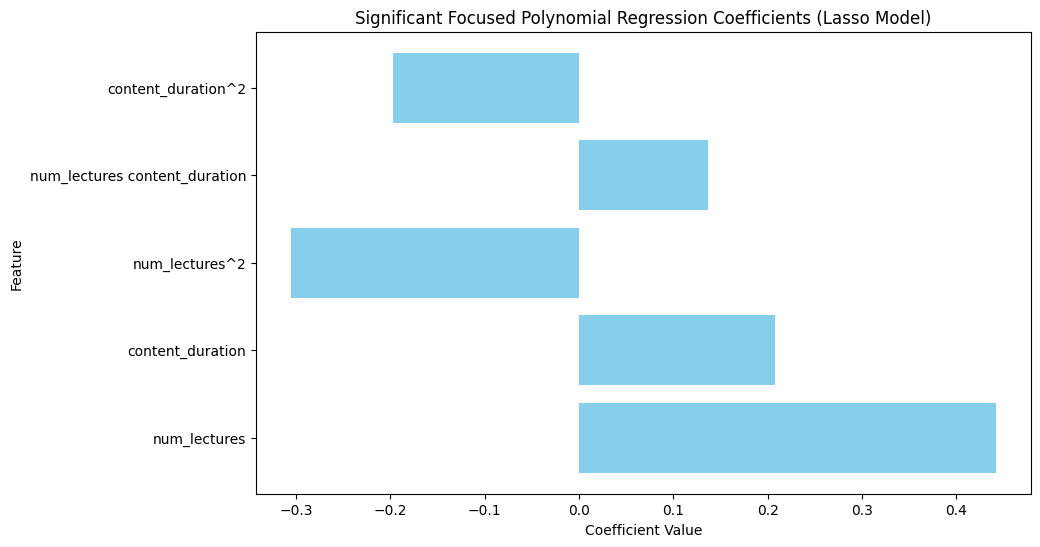

In [67]:
X = df_no_outliers_udemy[['num_lectures', 'content_duration']]  # Focused Independent variables
y = df_no_outliers_udemy['price_yeojohnson'] 

# Apply Polynomial Features (degree 2 for focused analysis)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a Lasso regression model with focused polynomial features
lasso = LassoCV(cv=5, random_state=42).fit(X_poly_scaled, y)

# Evaluate the model
r2_lasso = lasso.score(X_poly_scaled, y)
mse_lasso = mean_squared_error(y, lasso.predict(X_poly_scaled))

print(f"Focused Lasso R-squared: {r2_lasso}")
print(f"Focused Lasso Mean Squared Error: {mse_lasso}")

# Display significant model coefficients (non-zero coefficients)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': lasso.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0]

print("\nSignificant Coefficients (Focused Lasso):")
print(significant_coefficients)

# Visualize significant coefficients for the focused Lasso model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Focused Polynomial Regression Coefficients (Lasso Model)')
plt.show()


Ridge R-squared (No Polynomials): 0.1020675795196323
Ridge Mean Squared Error (No Polynomials): 0.8979324204803678

Ridge Coefficients (No Polynomials):
            Feature  Coefficient
0      num_lectures     0.215568
1  content_duration     0.118690


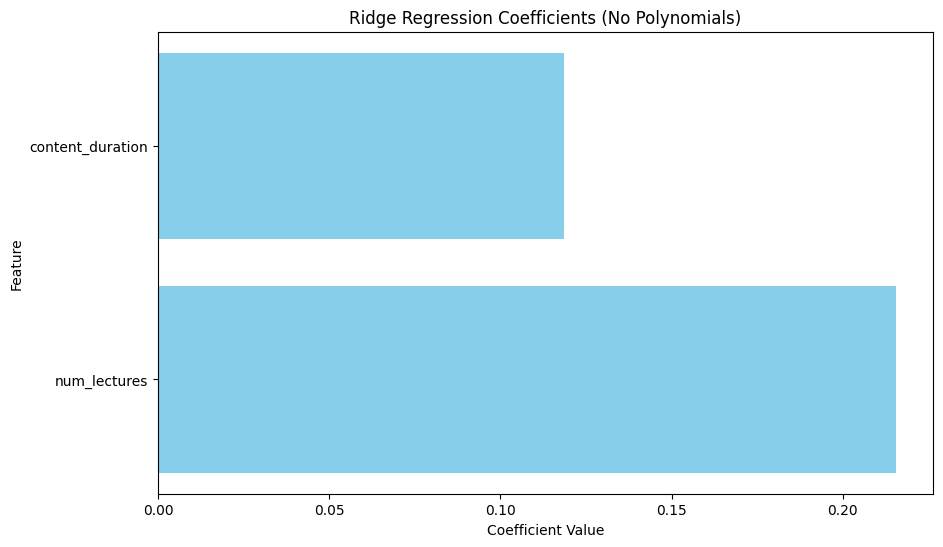

In [68]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a Ridge regression model without polynomial features
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(X_scaled, y)

# Evaluate the model
r2_ridge = ridge.score(X_scaled, y)
mse_ridge = mean_squared_error(y, ridge.predict(X_scaled))

print(f"Ridge R-squared (No Polynomials): {r2_ridge}")
print(f"Ridge Mean Squared Error (No Polynomials): {mse_ridge}")

# Display significant model coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_
})
print("\nRidge Coefficients (No Polynomials):")
print(coefficients)

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Ridge Regression Coefficients (No Polynomials)')
plt.show()


Ridge regression

Ridge R-squared: 0.14958596415875647
Ridge Mean Squared Error: 0.8504140358412436

Significant Coefficients (Ridge Regression):
                                              Feature  Coefficient
0                         num_subscribers_num_reviews    -0.169396
1                                        num_lectures     0.309314
2                                    content_duration     0.115655
7                       num_subscribers_num_reviews^2     0.163635
8            num_subscribers_num_reviews num_lectures     0.126838
13  num_subscribers_num_reviews subject_Web Develo...    -0.168292
14                                     num_lectures^2    -0.280768
16              num_lectures subject_Business Finance     0.200159
19               num_lectures subject_Web Development     0.179163
20                                 content_duration^2    -0.134649


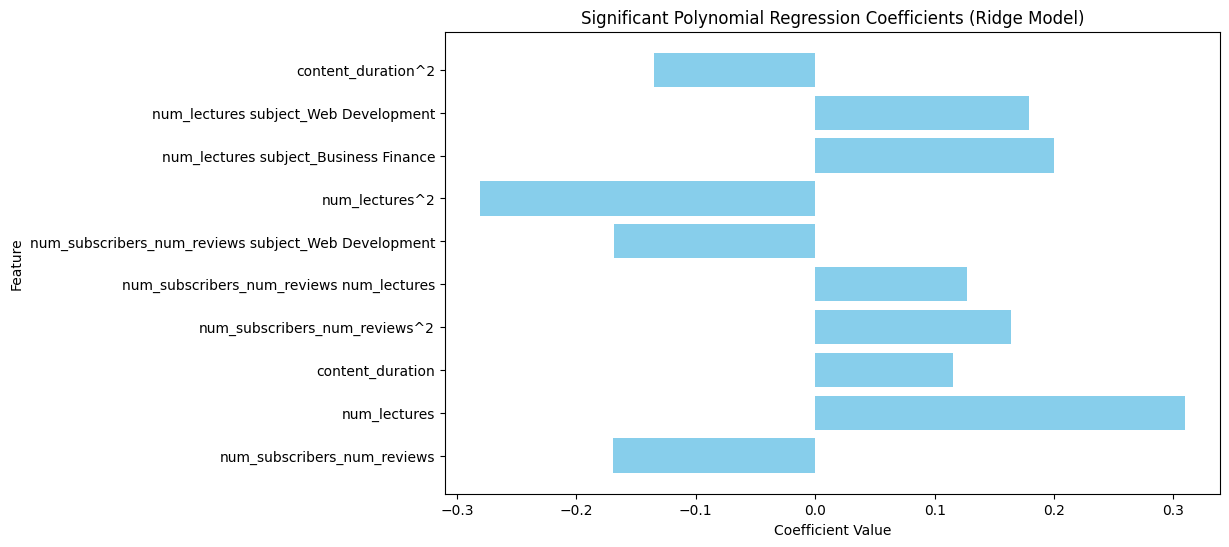

In [85]:
X = df_no_outliers_udemy[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'subject']]  
y = df_no_outliers_udemy['price_yeojohnson'] 

X = pd.get_dummies(X, drop_first=False).astype(float)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a Ridge regression model with polynomial features
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(X_poly_scaled, y)

# Evaluate the model
r2_ridge = ridge.score(X_poly_scaled, y)
mse_ridge = mean_squared_error(y, ridge.predict(X_poly_scaled))

print(f"Ridge R-squared: {r2_ridge}")
print(f"Ridge Mean Squared Error: {mse_ridge}")

# Display significant model coefficients (absolute value > 0.1)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': ridge.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

print("\nSignificant Coefficients (Ridge Regression):")
print(significant_coefficients)

# Visualize significant coefficients for the Ridge model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Polynomial Regression Coefficients (Ridge Model)')
plt.show()


Ridge for every subject


Processing subject: Business Finance
Ridge R-squared for Business Finance: 0.13809548337699085
Ridge Mean Squared Error for Business Finance: 0.9159884165906259

Significant Coefficients for Business Finance (Ridge Regression):
                                         Feature  Coefficient
0                    num_subscribers_num_reviews    -0.319985
1                                   num_lectures     0.505277
2                               content_duration     0.110358
6                  num_subscribers_num_reviews^2     0.328158
7       num_subscribers_num_reviews num_lectures    -0.710737
8   num_subscribers_num_reviews content_duration     0.729601
12                                num_lectures^2    -0.337157
13                 num_lectures content_duration     0.246034
17                            content_duration^2    -0.355050


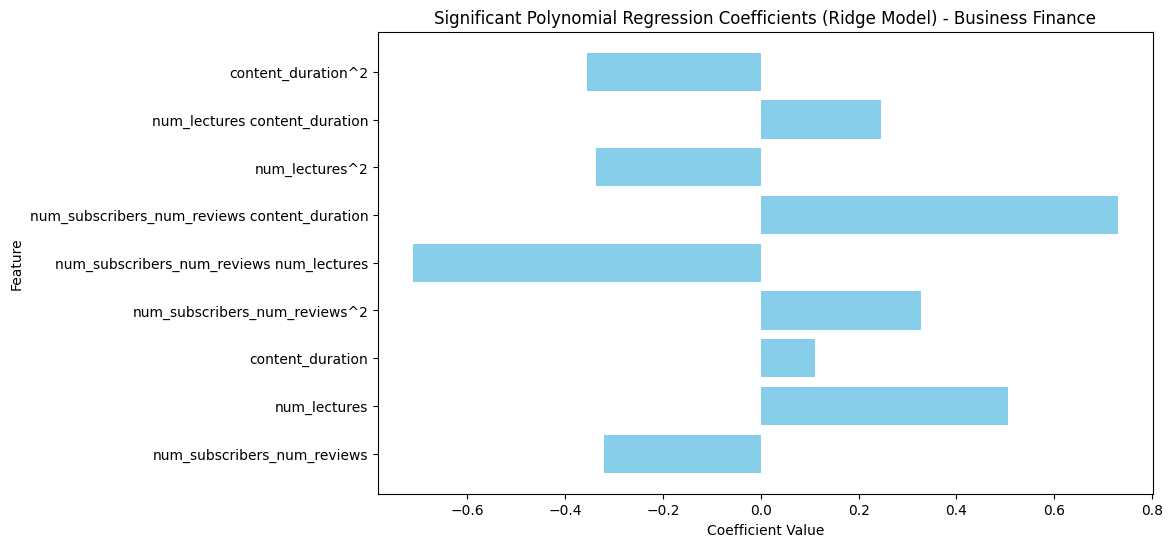


Processing subject: Graphic Design
Ridge R-squared for Graphic Design: 0.18905784447640395
Ridge Mean Squared Error for Graphic Design: 0.6839526624399547

Significant Coefficients for Graphic Design (Ridge Regression):
                                         Feature  Coefficient
0                    num_subscribers_num_reviews    -0.620029
1                                   num_lectures     0.786287
2                               content_duration    -0.114853
6                  num_subscribers_num_reviews^2     0.392353
7       num_subscribers_num_reviews num_lectures     1.113947
8   num_subscribers_num_reviews content_duration    -0.810308
12                                num_lectures^2    -0.445294
13                 num_lectures content_duration    -0.267740
15               num_lectures level_Expert Level    -0.211421
17                            content_duration^2     0.338378


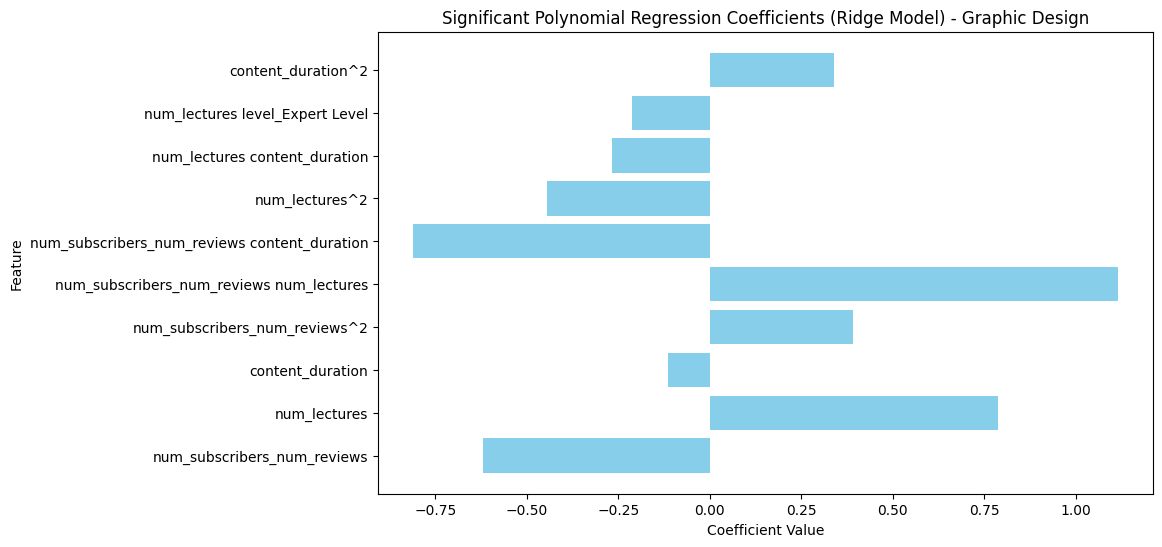


Processing subject: Musical Instruments
Ridge R-squared for Musical Instruments: 0.21198018379888983
Ridge Mean Squared Error for Musical Instruments: 0.4554991738768646

Significant Coefficients for Musical Instruments (Ridge Regression):
                                         Feature  Coefficient
0                    num_subscribers_num_reviews    -0.252119
1                                   num_lectures     0.384524
6                  num_subscribers_num_reviews^2     0.106438
8   num_subscribers_num_reviews content_duration     0.243833
12                                num_lectures^2    -0.275065
14             num_lectures level_Beginner Level    -0.101849
18         content_duration level_Beginner Level     0.192217


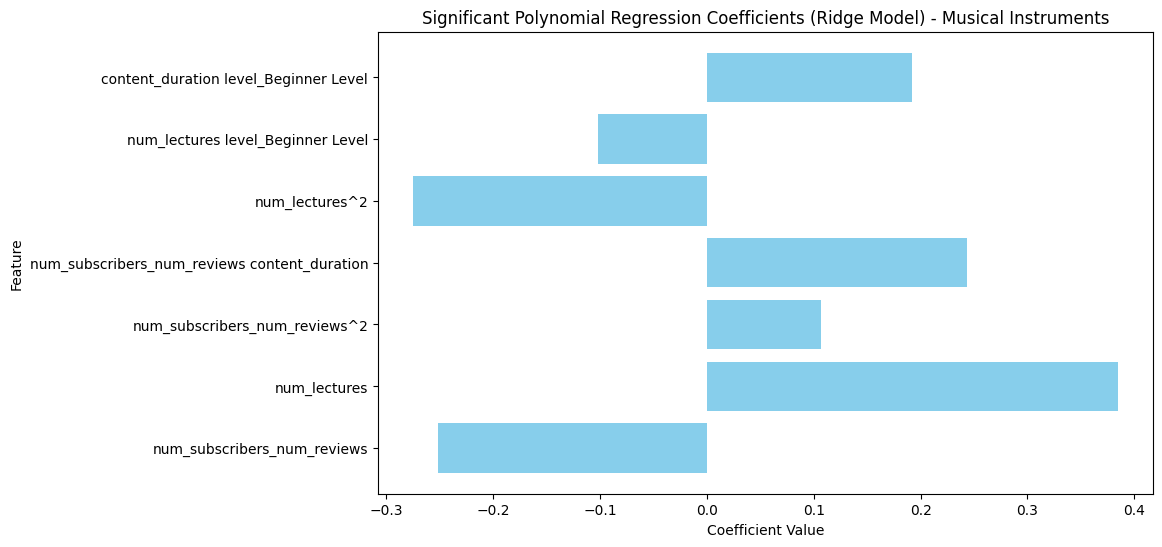


Processing subject: Web Development
Ridge R-squared for Web Development: 0.2075694051921836
Ridge Mean Squared Error for Web Development: 0.9705203138885754

Significant Coefficients for Web Development (Ridge Regression):
                                     Feature  Coefficient
0                num_subscribers_num_reviews    -0.590934
1                               num_lectures     0.536560
2                           content_duration     0.238427
6              num_subscribers_num_reviews^2     0.265476
7   num_subscribers_num_reviews num_lectures     0.203006
12                            num_lectures^2    -0.211892
13             num_lectures content_duration    -0.221020
15           num_lectures level_Expert Level    -0.182838
16     num_lectures level_Intermediate Level     0.152966
19       content_duration level_Expert Level     0.150299


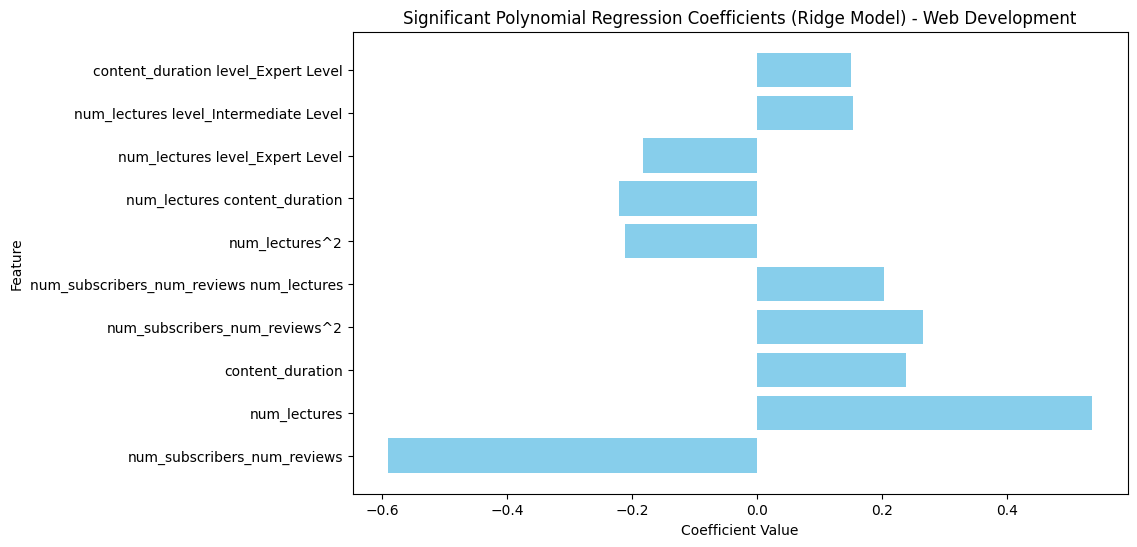


Summary for Business Finance:
R-squared: 0.13809548337699085
MSE: 0.9159884165906259

Summary for Graphic Design:
R-squared: 0.18905784447640395
MSE: 0.6839526624399547

Summary for Musical Instruments:
R-squared: 0.21198018379888983
MSE: 0.4554991738768646

Summary for Web Development:
R-squared: 0.2075694051921836
MSE: 0.9705203138885754


In [70]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level', 'subject'])

# Split the data by subject
subjects = df_no_outliers_udemy['subject'].unique()
subject_results = {}

for subject in subjects:
    print(f"\nProcessing subject: {subject}")
    
    # Filter the data for the current subject
    df_subject = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == subject]
    
    # Define the target variable and features
    X = df_subject[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
    y = df_subject['price_yeojohnson']

    # Encode categorical variables (e.g., 'level')
    X = pd.get_dummies(X, drop_first=True).astype(float)

    # Apply Polynomial Features (degree 2 for moderate complexity)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Standardize the features
    scaler = StandardScaler()
    X_poly_scaled = scaler.fit_transform(X_poly)

    # Fit a Ridge regression model with polynomial features
    ridge = Ridge(alpha=1.0)  # Regularization strength
    ridge.fit(X_poly_scaled, y)

    # Evaluate the model
    r2_ridge = ridge.score(X_poly_scaled, y)
    mse_ridge = mean_squared_error(y, ridge.predict(X_poly_scaled))

    print(f"Ridge R-squared for {subject}: {r2_ridge}")
    print(f"Ridge Mean Squared Error for {subject}: {mse_ridge}")

    # Display significant model coefficients (absolute value > 0.1)
    coefficients = pd.DataFrame({
        'Feature': poly.get_feature_names_out(X.columns),
        'Coefficient': ridge.coef_
    })
    significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

    print(f"\nSignificant Coefficients for {subject} (Ridge Regression):")
    print(significant_coefficients)

    # Store the results
    subject_results[subject] = {
        'R-squared': r2_ridge,
        'MSE': mse_ridge,
        'Significant Coefficients': significant_coefficients
    }

    # Visualize significant coefficients for the Ridge model
    plt.figure(figsize=(10, 6))
    plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title(f'Significant Polynomial Regression Coefficients (Ridge Model) - {subject}')
    plt.show()

# Print summary of results
for subject, results in subject_results.items():
    print(f"\nSummary for {subject}:")
    print(f"R-squared: {results['R-squared']}")
    print(f"MSE: {results['MSE']}")


Ridge for web dev vs all others


Processing subject: Web Development
Ridge R-squared for Web Development: 0.2075694051921836
Ridge Mean Squared Error for Web Development: 0.9705203138885754

Significant Coefficients for Web Development (Ridge Regression):
                                     Feature  Coefficient
0                num_subscribers_num_reviews    -0.590934
1                               num_lectures     0.536560
2                           content_duration     0.238427
6              num_subscribers_num_reviews^2     0.265476
7   num_subscribers_num_reviews num_lectures     0.203006
12                            num_lectures^2    -0.211892
13             num_lectures content_duration    -0.221020
15           num_lectures level_Expert Level    -0.182838
16     num_lectures level_Intermediate Level     0.152966
19       content_duration level_Expert Level     0.150299


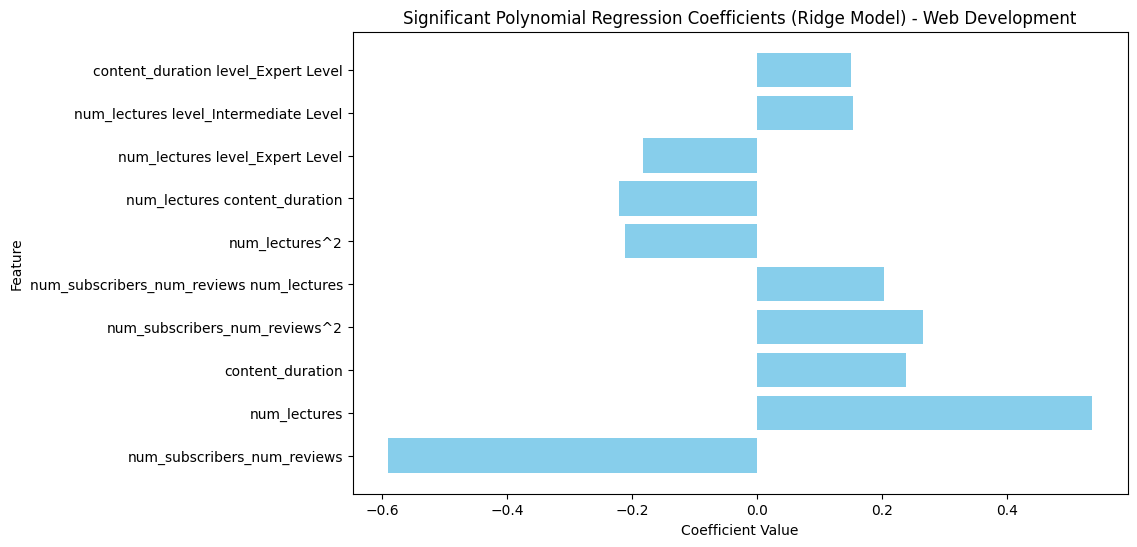


Processing subject: Other Subjects
Ridge R-squared for Other Subjects: 0.1324179493867046
Ridge Mean Squared Error for Other Subjects: 0.7661762329689366

Significant Coefficients for Other Subjects (Ridge Regression):
                                         Feature  Coefficient
0                    num_subscribers_num_reviews    -0.189155
1                                   num_lectures     0.430902
2                               content_duration     0.102807
8   num_subscribers_num_reviews content_duration     0.190689
12                                num_lectures^2    -0.364646
13                 num_lectures content_duration     0.275894
17                            content_duration^2    -0.254464


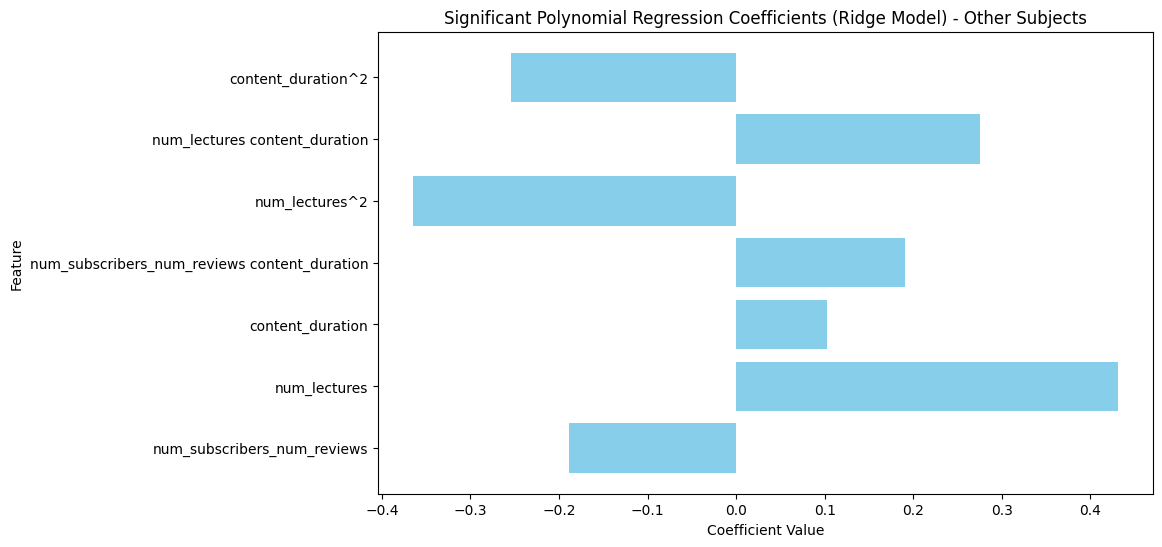


Summary for Web Development:
R-squared: 0.2075694051921836
MSE: 0.9705203138885754

Summary for Other Subjects:
R-squared: 0.1324179493867046
MSE: 0.7661762329689366


In [71]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level', 'subject'])

# Split the data into Web Development and Other subjects
web_dev_df = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']
other_subjects_df = df_no_outliers_udemy[df_no_outliers_udemy['subject'] != 'Web Development']

subject_results = {}

# Function to process a specific dataset
def process_subject(df, label):
    print(f"\nProcessing subject: {label}")
    
    # Define the target variable and features
    X = df[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
    y = df['price_yeojohnson']

    # Encode categorical variables (e.g., 'level')
    X = pd.get_dummies(X, drop_first=True).astype(float)

    # Apply Polynomial Features (degree 2 for moderate complexity)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Standardize the features
    scaler = StandardScaler()
    X_poly_scaled = scaler.fit_transform(X_poly)

    # Fit a Ridge regression model with polynomial features
    ridge = Ridge(alpha=1.0)  # Regularization strength
    ridge.fit(X_poly_scaled, y)

    # Evaluate the model
    r2_ridge = ridge.score(X_poly_scaled, y)
    mse_ridge = mean_squared_error(y, ridge.predict(X_poly_scaled))

    print(f"Ridge R-squared for {label}: {r2_ridge}")
    print(f"Ridge Mean Squared Error for {label}: {mse_ridge}")

    # Display significant model coefficients (absolute value > 0.1)
    coefficients = pd.DataFrame({
        'Feature': poly.get_feature_names_out(X.columns),
        'Coefficient': ridge.coef_
    })
    significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

    print(f"\nSignificant Coefficients for {label} (Ridge Regression):")
    print(significant_coefficients)

    # Visualize significant coefficients for the Ridge model
    plt.figure(figsize=(10, 6))
    plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title(f'Significant Polynomial Regression Coefficients (Ridge Model) - {label}')
    plt.show()

    # Store the results
    subject_results[label] = {
        'R-squared': r2_ridge,
        'MSE': mse_ridge,
        'Significant Coefficients': significant_coefficients
    }

# Process Web Development
process_subject(web_dev_df, 'Web Development')

# Process Other Subjects
process_subject(other_subjects_df, 'Other Subjects')

# Print summary of results
for subject, results in subject_results.items():
    print(f"\nSummary for {subject}:")
    print(f"R-squared: {results['R-squared']}")
    print(f"MSE: {results['MSE']}")


Ridge of degree 4 only for web dev - R square 0.26

Ridge R-squared for Web Development: 0.2609849474128456
Ridge Mean Squared Error for Web Development: 0.9051002390678928

Significant Coefficients for Web Development (Ridge Regression):
                                           Feature  Coefficient
0                      num_subscribers_num_reviews    -0.810681
1                                     num_lectures     0.650949
2                                 content_duration     0.381329
6                    num_subscribers_num_reviews^2     1.269274
8     num_subscribers_num_reviews content_duration     0.166658
..                                             ...          ...
176          content_duration^3 level_Expert Level    -0.103843
177    content_duration^3 level_Intermediate Level     0.357690
178      content_duration^2 level_Beginner Level^2     0.190625
183  content_duration^2 level_Intermediate Level^2    -0.404881
193    content_duration level_Intermediate Level^3     0.167676

[72 rows x 2 columns]


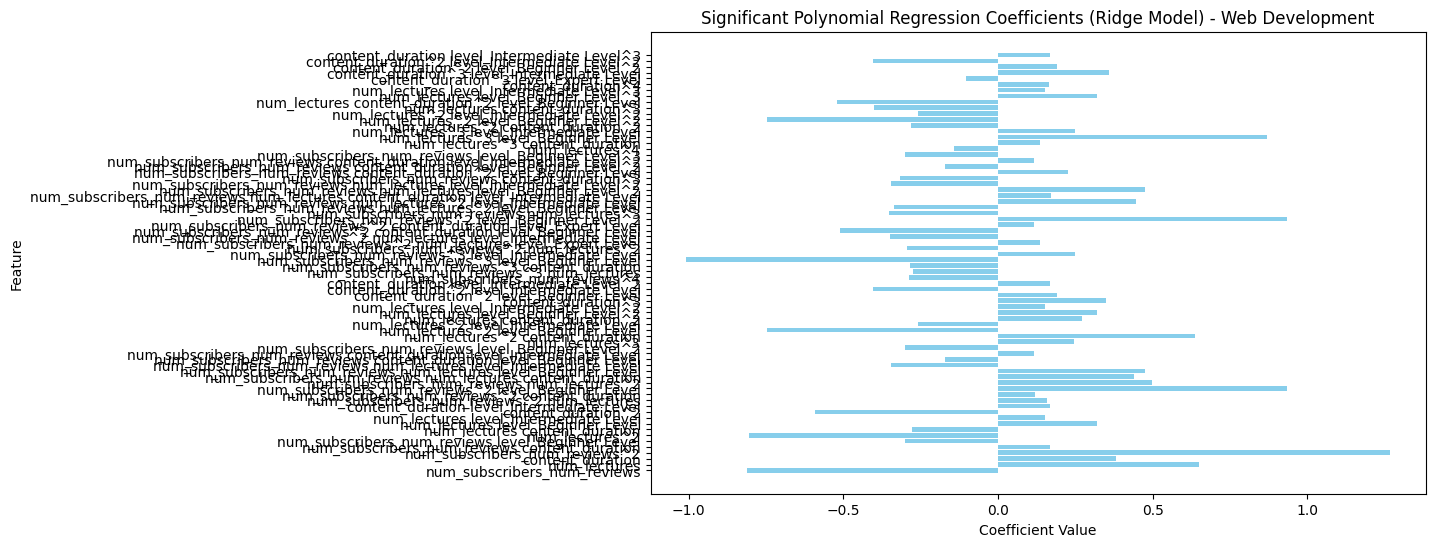

In [72]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level', 'subject'])

# Filter the data for Web Development only
web_dev_df = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

# Define the target variable and features
X = web_dev_df[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
y = web_dev_df['price_yeojohnson']

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Apply Polynomial Features (degree 2 for moderate complexity)
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Fit a Ridge regression model with polynomial features
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(X_poly_scaled, y)

# Evaluate the model
r2_ridge = ridge.score(X_poly_scaled, y)
mse_ridge = mean_squared_error(y, ridge.predict(X_poly_scaled))

print(f"Ridge R-squared for Web Development: {r2_ridge}")
print(f"Ridge Mean Squared Error for Web Development: {mse_ridge}")

# Display significant model coefficients (absolute value > 0.1)
coefficients = pd.DataFrame({
    'Feature': poly.get_feature_names_out(X.columns),
    'Coefficient': ridge.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

print("\nSignificant Coefficients for Web Development (Ridge Regression):")
print(significant_coefficients)

# Visualize significant coefficients for the Ridge model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Polynomial Regression Coefficients (Ridge Model) - Web Development')
plt.show()


RIDGE LOG KEEP IT

Ridge R-squared for Web Development with Log Transform: 0.20613126343361865
Ridge Mean Squared Error for Web Development with Log Transform: 0.972281661570106

Significant Coefficients for Web Development (Ridge Regression with Log Transform):
                       Feature  Coefficient
0  log_num_subscribers_reviews    -0.236426
1                 num_lectures     0.186665
2         log_content_duration     0.330986


C:\Users\teodo\AppData\Local\Temp\ipykernel_19296\4095171678.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_num_subscribers_reviews'] = np.log1p(X['num_subscribers_num_reviews'])
C:\Users\teodo\AppData\Local\Temp\ipykernel_19296\4095171678.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_content_duration'] = np.log1p(X['content_duration'])


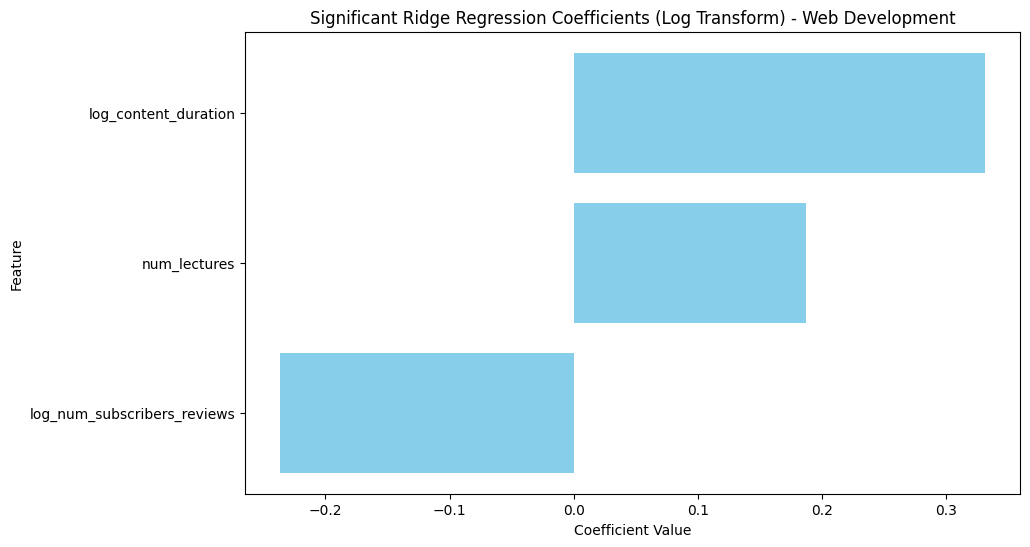

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge


# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'subject'])

# Filter the data for Web Development only
web_dev_df = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

# Define the target variable and features
X = web_dev_df[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
y = web_dev_df['price_yeojohnson']

# Log-transform the continuous variables
X['log_num_subscribers_reviews'] = np.log1p(X['num_subscribers_num_reviews'])
X['log_content_duration'] = np.log1p(X['content_duration'])

# Drop original variables and keep transformed ones
X = X[['log_num_subscribers_reviews', 'num_lectures', 'log_content_duration', 'level']]

# Encode categorical variables (e.g., 'level')
X = pd.get_dummies(X, drop_first=True).astype(float)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a Ridge regression model
ridge = Ridge(alpha=1.0)  # Regularization strength
ridge.fit(X_scaled, y)

# Evaluate the model
r2_ridge = ridge.score(X_scaled, y)
mse_ridge = mean_squared_error(y, ridge.predict(X_scaled))

print(f"Ridge R-squared for Web Development with Log Transform: {r2_ridge}")
print(f"Ridge Mean Squared Error for Web Development with Log Transform: {mse_ridge}")

# Display significant model coefficients (absolute value > 0.1)
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_
})
significant_coefficients = coefficients[coefficients['Coefficient'].abs() > 0.1]

print("\nSignificant Coefficients for Web Development (Ridge Regression with Log Transform):")
print(significant_coefficients)

# Visualize significant coefficients for the Ridge model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients['Feature'], significant_coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Ridge Regression Coefficients (Log Transform) - Web Development')
plt.show()


cross validation for degree 4 and log


Cross-validation for Log Transform Model
Cross-validated R-squared (Log Transform): 0.1245

Cross-validation for Polynomial Features Model
Cross-validated R-squared (Polynomial Features, Degree 4): -6.1036

Significant Coefficients for Web Development (Polynomial Features, Degree 4):
                                           Feature  Coefficient
0                      num_subscribers_num_reviews    -0.810681
1                                     num_lectures     0.650949
2                                 content_duration     0.381329
6                    num_subscribers_num_reviews^2     1.269274
8     num_subscribers_num_reviews content_duration     0.166658
..                                             ...          ...
176          content_duration^3 level_Expert Level    -0.103843
177    content_duration^3 level_Intermediate Level     0.357690
178      content_duration^2 level_Beginner Level^2     0.190625
183  content_duration^2 level_Intermediate Level^2    -0.404881
193    con

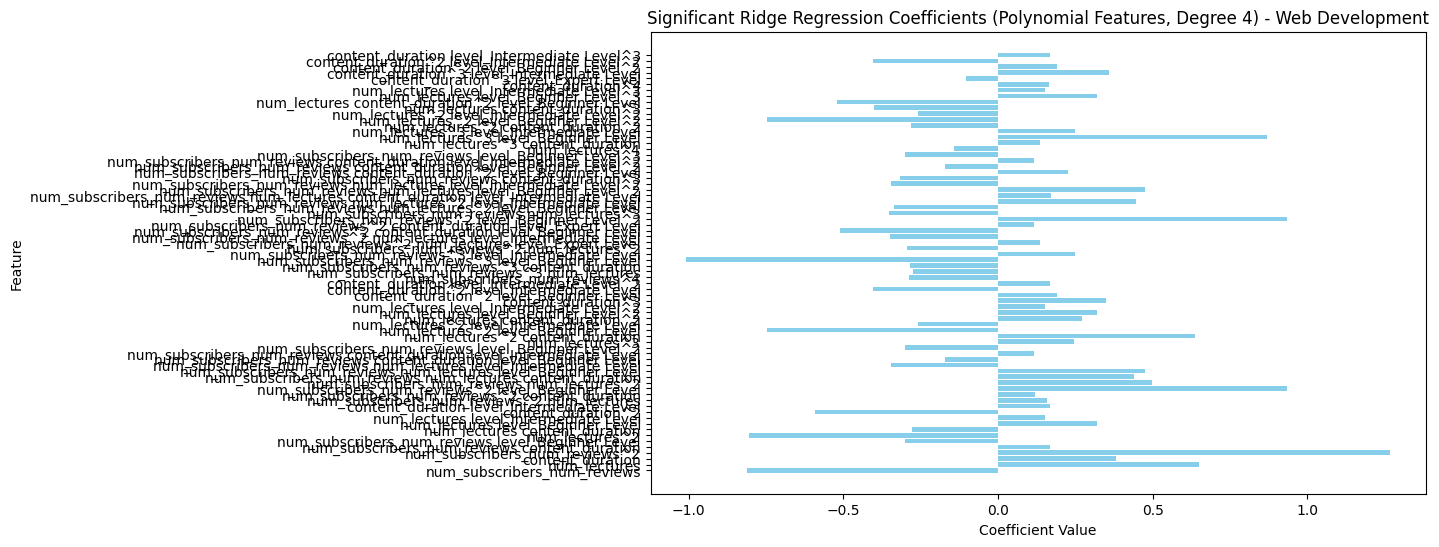

In [74]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure we're working with the df_no_outliers_udemy dataframe
df_no_outliers_udemy = df_no_outliers_udemy.dropna(subset=['price_yeojohnson', 'num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level', 'subject'])

# Filter the data for Web Development only
web_dev_df = df_no_outliers_udemy[df_no_outliers_udemy['subject'] == 'Web Development']

# Define the target variable and features
X = web_dev_df[['num_subscribers_num_reviews', 'num_lectures', 'content_duration', 'level']]
y = web_dev_df['price_yeojohnson']

# Cross-validation for Log Transform Model
print("\nCross-validation for Log Transform Model")
# Log-transform the continuous variables
X_log = X.copy()
X_log['log_num_subscribers'] = np.log1p(X_log['num_subscribers_num_reviews'])
X_log['log_content_duration'] = np.log1p(X_log['content_duration'])
X_log = X_log[['log_num_subscribers', 'num_lectures', 'log_content_duration', 'level']]

# Encode categorical variables (e.g., 'level')
X_log = pd.get_dummies(X_log, drop_first=True).astype(float)

# Standardize the features
scaler_log = StandardScaler()
X_log_scaled = scaler_log.fit_transform(X_log)

# Fit a Ridge regression model
ridge_log = Ridge(alpha=1.0)
ridge_log.fit(X_log_scaled, y)

# Cross-validation scores for Log Transform
cv_scores_log = cross_val_score(ridge_log, X_log_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared (Log Transform): {np.mean(cv_scores_log):.4f}")

# Polynomial Features Model (Degree 4)
print("\nCross-validation for Polynomial Features Model")
# Apply Polynomial Features (degree 4)
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(pd.get_dummies(X, drop_first=True).astype(float))

# Standardize the features
scaler_poly = StandardScaler()
X_poly_scaled = scaler_poly.fit_transform(X_poly)

# Fit a Ridge regression model with polynomial features
ridge_poly = Ridge(alpha=1.0)
ridge_poly.fit(X_poly_scaled, y)

# Cross-validation scores for Polynomial Model
cv_scores_poly = cross_val_score(ridge_poly, X_poly_scaled, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared (Polynomial Features, Degree 4): {np.mean(cv_scores_poly):.4f}")

# Display significant model coefficients for Polynomial Model (absolute value > 0.1)
coefficients_poly = pd.DataFrame({
    'Feature': poly.get_feature_names_out(pd.get_dummies(X, drop_first=True).columns),
    'Coefficient': ridge_poly.coef_
})
significant_coefficients_poly = coefficients_poly[coefficients_poly['Coefficient'].abs() > 0.1]

print("\nSignificant Coefficients for Web Development (Polynomial Features, Degree 4):")
print(significant_coefficients_poly)

# Visualize significant coefficients for Polynomial Model
plt.figure(figsize=(10, 6))
plt.barh(significant_coefficients_poly['Feature'], significant_coefficients_poly['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Significant Ridge Regression Coefficients (Polynomial Features, Degree 4) - Web Development')
plt.show()
